# calculate the reference values for the 4 outputs

In [63]:
import numpy as np
from glob import glob
from skimage.morphology import skeletonize_3d
from medutils.medutils import load_itk, save_itk
import SimpleITK as sitk
import itk
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import disk,diamond,rectangle,square,erosion,dilation,opening,closing,skeletonize
import pickle
import pandas as pd
import json
import matplotlib
import copy
import pingouin as pg

from scipy.stats import pearsonr


In [96]:
file_fpath = 'all_biomarkers_correct3.csv'
df=pd.read_csv(file_fpath)

In [97]:
net_ts_pred_fpath = "/home/jjia/data/lung_function/lung_function/scripts/results/experiments/2426/test_pred.csv"
df_net_ts_pred = pd.read_csv(net_ts_pred_fpath)

In [98]:
# remove one patient without the % predicted values because of the insuffient technique
pat_id_wo_pred = 8334199
df_net_ts_pred = df_net_ts_pred[df_net_ts_pred['pat_id']!=pat_id_wo_pred]


In [127]:
# extract testing dataset form the whole dataset
first_ts_pat_id = 7957098
test_df = df.loc[df['PatID'] >= first_ts_pat_id]


In [128]:
test_df = test_df.set_axis(range(len(test_df)))
df_net_ts_pred = df_net_ts_pred.set_axis(range(len(df_net_ts_pred)))

df_net_ts_pred = df_net_ts_pred.rename(columns={'DLCOc_SB':'DLCOc', 'TLC_He': 'TLC'})

In [130]:
# icc
def icc(label, pred, columns = []):
    label['ID'] = np.arange(1, len(label) + 1)
    label['rater'] = 'label'

    pred['ID'] = np.arange(1, len(pred) + 1)
    pred['rater'] = 'pred'

    data = pd.concat([label, pred], axis=0)

    for column in columns:
        icc = pg.intraclass_corr(data=data, targets='ID', raters='rater', ratings=column).round(2)
        icc = icc.set_index("Type")
        icc = icc.loc['ICC2']['ICC']
        print(f"icc for {column}: {icc}")
    return icc
        # prefix = label_fpath.split("/")[-1].split("_")[0]
        # icc_dict['icc_' + prefix + '_' + column] = icc

In [131]:
icc_value = icc(test_df, df_net_ts_pred,columns=['DLCOc', 'FEV1', 'FVC', 'TLC'])


icc for DLCOc: 0.55
icc for FEV1: 0.76
icc for FVC: 0.7
icc for TLC: 0.67


In [132]:
for column in ['DLCOc', 'FEV1', 'FVC', 'TLC']:
    df_net_ts_pred[column+'PP'] = df_net_ts_pred[column] / test_df[pft_abs_name+"Ref"] * 100

In [133]:
df_net_ts_pred

,pat_id,FVC,DLCOc,FEV1,TLC,ID,rater,DLCOcPP,FEV1PP,FVCPP,TLCPP
0,7957098,2.846,4.684,2.490,4.113,1,pred,78.766816,41.872197,47.858744,69.164798
1,7977032,3.137,5.310,2.748,4.566,2,pred,100.926370,52.230822,59.624486,86.785274
2,8077626,3.025,5.414,2.592,4.430,3,pred,97.601273,46.727466,54.533404,79.862142
3,8160998,4.027,7.156,3.572,5.700,4,pred,128.368501,64.076619,72.238674,102.249924
4,8189796,2.988,5.016,2.627,4.336,5,pred,82.965558,43.451061,49.422067,71.718233
...,...,...,...,...,...,...,...,...,...,...,...
57,9523013,3.793,6.570,3.393,5.480,58,pred,83.164557,42.949367,48.012658,69.367089
58,9662556,4.030,7.100,3.695,5.800,59,pred,123.168851,64.099846,69.911334,100.616808
59,9861781,3.783,6.690,3.414,5.387,60,pred,94.009804,47.974510,53.159804,75.699673
60,9934096,2.600,4.496,2.139,3.855,61,pred,97.174406,46.231329,56.195164,83.320137


In [134]:
test_df_slim = test_df[['PatID','rater','DLCOc', 'FEV1', 'FVC', 'TLC','DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP' ]]

In [135]:
test_df_slim

,PatID,rater,DLCOc,FEV1,FVC,TLC,DLCOcPP,FEV1PP,FVCPP,TLCPP
0,7957098,label,9.205,3.635,4.555,5.352,118.0,116.0,117.0,90.0
1,7977032,label,5.710,2.810,3.950,5.840,82.0,110.0,121.0,111.0
2,8077626,label,5.433,2.741,3.642,5.658,73.0,98.0,103.0,102.0
3,8160998,label,4.094,2.878,4.059,6.578,54.0,99.0,110.0,118.0
4,8189796,label,5.301,2.629,3.568,5.139,68.0,91.0,97.0,85.0
...,...,...,...,...,...,...,...,...,...,...
57,9523013,label,6.741,3.492,4.117,5.214,60.0,82.0,80.0,66.0
58,9662556,label,6.551,3.666,4.340,5.188,78.0,102.0,102.0,90.0
59,9861781,label,5.380,3.870,4.900,6.120,56.0,100.0,100.0,86.0
60,9934096,label,4.800,2.057,2.706,4.673,79.0,99.0,102.0,101.0


In [136]:
icc_value = icc(test_df, df_net_ts_pred,columns=['DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'])


icc for DLCOcPP: 0.2
icc for FEV1PP: 0.06
icc for FVCPP: 0.09
icc for TLCPP: 0.49


In [ ]:
plt.figure()


In [69]:
# show the r between net output and pft absolute values
for net_out_name, pft_abs_name in zip(['DLCOc_SB', 'FEV1', 'FVC', 'TLC_He'],['DLCOc', 'FEV1', 'FVC', 'TLC']):
    corr, p_value = pearsonr(df_net_ts_pred[net_out_name], test_df[pft_abs_name])
    mean = (df_net_ts_pred[net_out_name] - test_df[pft_abs_name]).mean()
    std = (df_net_ts_pred[net_out_name] - test_df[pft_abs_name]).std()
    print(f"{pft_abs_name}:\t r: {corr:.3f}, mean: {mean:.2f}, std, {std:.2f}")
    


DLCOc:	 r: 0.614, mean: -0.61, std, 1.70
FEV1:	 r: 0.764, mean: 0.01, std, 0.54
FVC:	 r: 0.828, mean: -0.46, std, 0.60
TLC:	 r: 0.823, mean: -0.72, std, 0.79


In [61]:
assert len(df_net_ts_pred) == len(test_df)
df_net_ts_pred = df_net_ts_pred.set_axis(range(len(df_net_ts_pred)))
test_df = test_df.set_axis(range(len(test_df)))

In [62]:
# show the r between net output and pft absolute values
for net_out_name, pft_abs_name in zip(['DLCOc_SB', 'FEV1', 'FVC', 'TLC_He'],['DLCOc', 'FEV1', 'FVC', 'TLC']):
    corr, p_value = pearsonr(df_net_ts_pred[net_out_name]/test_df[pft_abs_name+"Ref"], test_df[pft_abs_name]/test_df[pft_abs_name+"Ref"])
    print(pft_abs_name + 'PP', corr)

DLCOcPP 0.24098050709944877
FEV1PP 0.39002495986930613
FVCPP 0.5448626733817346
TLCPP 0.6603650688872379


In [139]:
df_net_ts_pred

,pat_id,FVC,DLCOc,FEV1,TLC,ID,rater,DLCOcPP,FEV1PP,FVCPP,TLCPP
0,7957098,2.846,4.684,2.490,4.113,1,pred,78.766816,41.872197,47.858744,69.164798
1,7977032,3.137,5.310,2.748,4.566,2,pred,100.926370,52.230822,59.624486,86.785274
2,8077626,3.025,5.414,2.592,4.430,3,pred,97.601273,46.727466,54.533404,79.862142
3,8160998,4.027,7.156,3.572,5.700,4,pred,128.368501,64.076619,72.238674,102.249924
4,8189796,2.988,5.016,2.627,4.336,5,pred,82.965558,43.451061,49.422067,71.718233
...,...,...,...,...,...,...,...,...,...,...,...
57,9523013,3.793,6.570,3.393,5.480,58,pred,83.164557,42.949367,48.012658,69.367089
58,9662556,4.030,7.100,3.695,5.800,59,pred,123.168851,64.099846,69.911334,100.616808
59,9861781,3.783,6.690,3.414,5.387,60,pred,94.009804,47.974510,53.159804,75.699673
60,9934096,2.600,4.496,2.139,3.855,61,pred,97.174406,46.231329,56.195164,83.320137


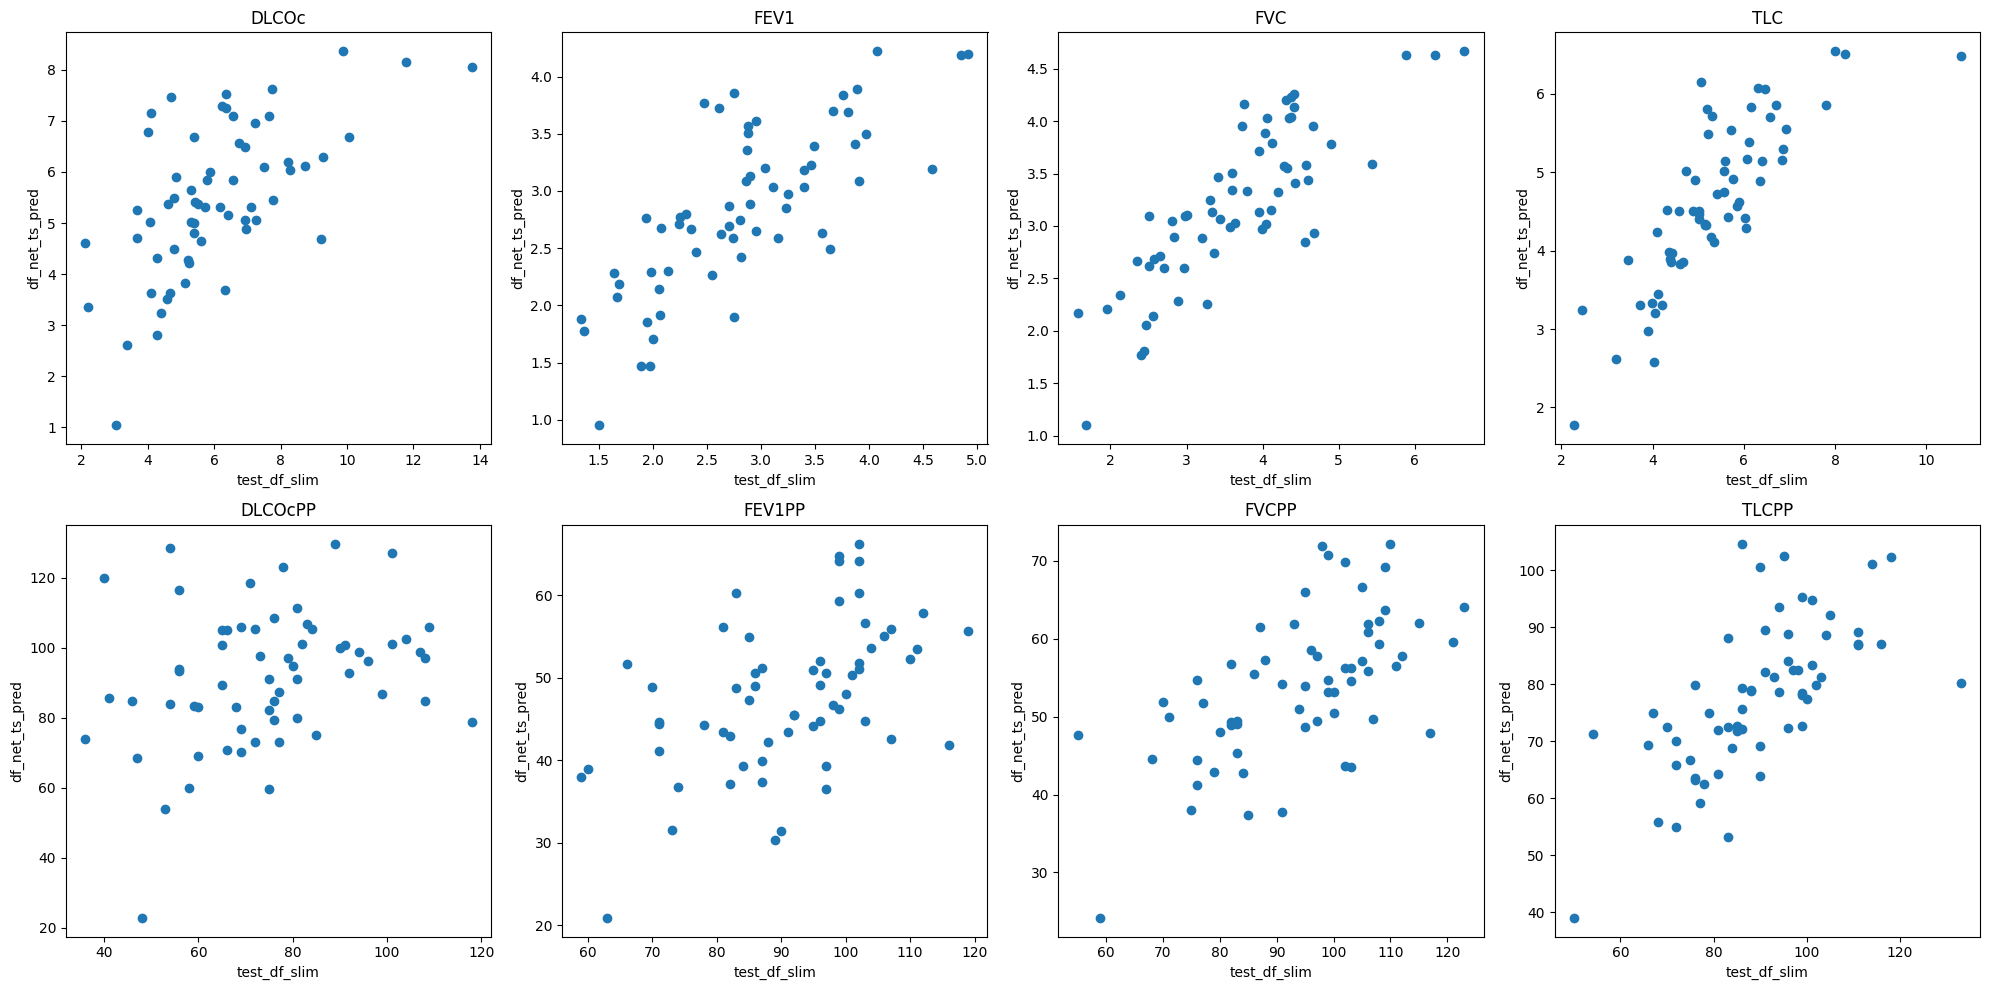

In [140]:
import matplotlib.pyplot as plt

# 列名列表
cols = ['DLCOc', 'FEV1', 'FVC', 'TLC','DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP']

# 创建一个 2 行 4 列的子图
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# 循环遍历每个列
for i, name in enumerate(cols):
    # 计算子图的行和列
    row = i // 4
    col = i % 4
    
    # 绘制散点图
    axs[row, col].scatter(test_df_slim[name], df_net_ts_pred[name])
    
    # 设置子图标题和坐标轴标签
    axs[row, col].set_title(name)
    axs[row, col].set_xlabel('test_df_slim')
    axs[row, col].set_ylabel('df_net_ts_pred')
    
# 调整子图之间的间距和边距
plt.tight_layout()

# 显示图像
plt.show()


In [159]:
df_net_ts_pred['FEV1'] / test_df_slim['FEV1PP']*100

0     2.146552
1     2.498182
2     2.644898
3     3.608081
4     2.886813
        ...   
57    4.137805
58    3.622549
59    3.414000
60    2.160606
61    2.306061
Length: 62, dtype: float64

In [161]:
MAPE_FEV1 = ((df_net_ts_pred['FEV1'] - test_df_slim['FEV1']).abs()/test_df_slim['FEV1']).sum()

In [167]:
MAPE_FEV1PP = ((df_net_ts_pred['FEV1'] - test_df_slim['FEV1PP']).abs()/test_df_slim['FEV1PP']).sum()

In [162]:
MAPE_FEV1

10.151414022272814

In [168]:
MAPE_FEV1PP

58.299997508762516

In [152]:
MAPE_FEV1PP

29.34071995927858

In [166]:
(df_net_ts_pred['FEV1PP'] - df_net_ts_pred['FEV1PP']).abs()/df_net_ts_pred['FEV1PP']

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
57    0.0
58    0.0
59    0.0
60    0.0
61    0.0
Name: FEV1PP, Length: 62, dtype: float64